# Simpel FFN

In [1]:
import torch
from torch.autograd import Variable
from torch.nn.parameter import Parameter
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init

%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score

from data_loader import parse_data

import glob
import pandas as pd
import branca

Ting der skal laves med den simple model: 

- Kun kig på en vej ad gangen 
- Lave en kode for hvilken vej man kigger på

- Tilføje tidslige data, så modellen ved hvilken tid det er på dagen 
- Kigge på en dag ad gangen, så der ikke er korrelation mellem nat og morgen efter

# Import data

In [2]:
files_train = glob.glob('../data/train/*/vehicle-position-matched-online.csv')
files_test = glob.glob('../data/test/*/vehicle-position-matched-online.csv')
train = parse_data(files_train)
test = parse_data(files_test)

train = train.pivot(index='Time',columns='wayId',values='mean')
test = test.pivot(index='Time',columns='wayId',values='mean')
print("Train Shape: ",train.shape)
print("Test Shape: ",test.shape)

Train Shape:  (388, 80)
Test Shape:  (97, 80)


In [11]:
print("Train before interpolate: ",train.isnull().sum().sum())
print("Test before interpolate: ",test.isnull().sum().sum())
train = train.interpolate(limit=10, limit_direction='both')
test = test.interpolate()
print("Train after interpolate: ",train.isnull().sum().sum())
print("Test after interpolate: ",test.isnull().sum().sum())
#train.head()

Train before interpolate:  9
Test before interpolate:  8
Train after interpolate:  0
Test after interpolate:  8


768
80


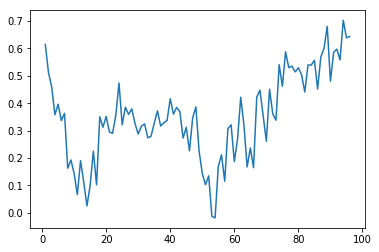

In [5]:
mean_value = test.values.mean(1)
#plt.plot(test.values[:,39]

plt.plot(mean_value)
         
print(12*(22-6)*4)
print(train.shape[1])
#print(mean_value)

# Describe the model

In [13]:
#Hyperparameters
num_l1 = 25
num_ways = train.shape[1]

# define network
class Net(nn.Module):
    def __init__(self, num_hidden1, num_output):
        super(Net, self).__init__()
        
        #Dropput and Batchnorm Functions
        self.dropout = nn.Dropout2d(0.2)
        self.batch1 = nn.BatchNorm1d(num_l1)
        
        # Input layer
        #Using kaiming normalization
        self.W_1 = Parameter(init.kaiming_normal_(torch.Tensor(num_hidden1,12)))
        self.b_1 = Parameter(init.constant_(torch.Tensor(num_hidden1), 0))
        
        # Hidden layer 1
        self.W_2 = Parameter(init.kaiming_normal_(torch.Tensor(1, num_hidden1)))
        self.b_2 = Parameter(init.constant_(torch.Tensor(1), 0))        
               
        # define activation function in constructor
        self.activation = torch.nn.ReLU()

    def forward(self, x):
        x = F.linear(x, self.W_1, self.b_1)
        x = self.activation(x)
        
        x = F.linear(x, self.W_2, self.b_2)
        return x
        #return F.softmax(x, dim=1)

net = Net(num_l1, num_ways)

#Adam Optimizer with L2 weight decay  
optimizer = optim.Adam(net.parameters(),lr = 1e-3, weight_decay = 1e-5)

criterion = nn.MSELoss()
#criterion = nn.CrossEntropyLoss()

In [14]:
#Test the forward pass with dummy data
x = np.random.normal(0, 1, (45, 12)).astype('float32')

print(net(Variable(torch.from_numpy(x))).size())

torch.Size([45, 1])


# Train and test the model

In [17]:
# setting hyperparameters and gettings epoch sizes
batch_size = 12
num_epochs = 50
num_samples_train = train.shape[0]-1
num_batches_train = num_samples_train - batch_size
num_samples_test = test.shape[0]-1
num_batches_test = num_samples_test - batch_size 

# setting up lists for handling loss/accuracy
cur_loss = 0
losses = []
train_mae, test_mae = [],[]
test_AE, train_AE = [], []
get_slice = lambda i, size: range(i - size, i)

for epoch in range(num_epochs):
    ## Train
    cur_loss = 0
    net.train()
    for i in range(batch_size,num_batches_train):
        slce = get_slice(i, batch_size)
        x_batch = Variable(torch.from_numpy(train.values[slce,:]).float().transpose(0, 1))
        output = net(x_batch).squeeze()
        #print(output)
        
        # compute gradients given loss
        target_batch = Variable(torch.from_numpy(train.values[i+1,:]).float())
        batch_loss = criterion(output, target_batch)
        
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
        
        cur_loss += batch_loss   
    losses.append(cur_loss / batch_size)

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        x_batch = Variable(torch.from_numpy(train.values[slce,:]).float().transpose(0, 1))
        
        output = net(x_batch)

        train_AE.append(sum(abs(np.squeeze(output.data.numpy())-train.values[i+1,:]))/batch_size)

    
    ### Evaluate validation
    val_preds, val_targs = [], []
    for i in range(batch_size,num_batches_test):
        slce = get_slice(i, batch_size)
        x_batch = Variable(torch.from_numpy(test.values[slce,:]).float().transpose(0, 1))
        
        output = net(x_batch)
        
        test_AE.append(sum(abs(np.squeeze(output.data.numpy())-test.values[i+1,:]))/batch_size)

    train_mae.append(sum(train_AE)/len(train_AE))
    test_mae.append(sum(test_AE)/len(test_AE))
       
    print(test_mae)
    
    print(train_mae)

    if epoch % 10 == 0:
        print("Epoch %2i, Loss: %f, Train MAE %f, Test MAE %f" % (
                epoch+1, losses[-1], train_mae[-1], test_mae[-1]))

epoch = np.arange(len(train_acc))
plt.figure()
plt.plot(epoch, train_acc, 'r', epoch, valid_acc, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('Acc')

759
[4.546776696635926]
[nan]
Epoch  1, Loss: 39.942440, Train MAE nan, Test MAE 4.546777
[4.546776696635926, 4.546780846860468]
[nan, nan]
[4.546776696635926, 4.546780846860468, 4.546782474629952]
[nan, nan, nan]


KeyboardInterrupt: 

In [ ]:
x = Variable(torch.from_numpy(test.values).float().transpose(0, 1))
y=net(x)

In [ ]:
get_slice = lambda i, size: range(i - size, i)

for i in range(12,14):
    slce = get_slice(i, 12)
    print(slce)